In [1]:
# import pyspark to process large files and create a new spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, asc, desc, to_timestamp, when
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

spark = SparkSession\
    .builder\
    .master('local[*]')\
    .config("spark.driver.memory", "4g")\
    .appName('process_tripdata')\
    .getOrCreate()

In [2]:
# read 2019-05 data
fhv_data = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/fhv_tripdata_2019-10.csv', header=True)
fhvhv_data = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/fhvhv_tripdata_2019-10.csv', header=True)

# load taxi zones
taxi_zones = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/taxi_zone_lookup.csv', header=True)

# load app lookup
apps_lookup = spark\
    .read\
    .csv('/media/felipe/Files/repos/tcc/nyc_data/csv/hvfhs_licenses.csv', header=True)

# load NYC shape file to geopandas
gdf = geopandas.read_file('/media/felipe/Files/repos/tcc/nyc_data/shapes/taxi_zones/taxi_zones.dbf')

In [3]:
# get mar data count -> 1,908,099 + 21,734,767
# print('fhv', fhv_data.count())
# print('fhvhv', fhvhv_data.count())

In [4]:
# filter off null PU and DO location IDs
fhv_data.createOrReplaceTempView("FHV_DATA_TEMP_VIEW")
fhv_data = spark.sql("SELECT * FROM FHV_DATA_TEMP_VIEW WHERE PULocationID IS NOT NULL AND DOLocationID IS NOT NULL")

fhvhv_data.createOrReplaceTempView("FHVHV_DATA_TEMP_VIEW")
fhvhv_data = spark.sql("SELECT * FROM FHVHV_DATA_TEMP_VIEW WHERE PULocationID IS NOT NULL AND DOLocationID IS NOT NULL")

In [5]:
# get apr data count after filtering -> 1,908,099 + 21,734,767
# print('fhv', fhv_data.count())
# print('fhvhv', fhvhv_data.count())

In [6]:
# convert PU and DO location ID cols to int and filter off unknown locations
fhv_data = fhv_data\
    .withColumn("PULocationID", fhv_data.PULocationID.cast('int'))\
    .withColumn("DOLocationID", fhv_data.DOLocationID.cast('int'))
fhv_data = fhv_data.where("PULocationID < 264 AND DOLocationID < 264")

fhvhv_data = fhvhv_data\
    .withColumn("PULocationID", fhvhv_data.PULocationID.cast('int'))\
    .withColumn("DOLocationID", fhvhv_data.DOLocationID.cast('int'))
fhvhv_data = fhvhv_data.where("PULocationID < 264 AND DOLocationID < 264")

# count how many trips did not depart from or arrive to unknown zones -> 237,815 + 21,059,243
# print('fhv', fhv_data.count())
# print('fhvhv', fhvhv_data.count())

In [7]:
# remove rows where PU and DO cols are 0
fhv_data.createOrReplaceTempView("FHV_DATA_TEMP_VIEW")
fhv_data = spark.sql("SELECT * FROM FHV_DATA_TEMP_VIEW WHERE PULocationID <> 0 AND DOLocationID <> 0")

fhvhv_data.createOrReplaceTempView("FHVHV_DATA_TEMP_VIEW")
fhvhv_data = spark.sql("SELECT * FROM FHVHV_DATA_TEMP_VIEW WHERE PULocationID <> 0 AND DOLocationID <> 0")

# count how many trips PU and DO locations are 0 -> 237,815 + 21,059,243
# print('fhv', fhv_data.count())
# print('fhvhv', fhvhv_data.count())

In [8]:
# OD matrix
od_size = 264 # 263 + 1 to account for 0-index in list
od_data = [[0 for x in range(od_size)] for y in range(od_size)]
od_cols = [str(x) for x in range(od_size)]

# fill feb OD matrix dataframe
fhv_data_collect = fhv_data.toLocalIterator()
for fhv_row in fhv_data_collect:
    origin = fhv_row.PULocationID
    destination = fhv_row.DOLocationID
    od_data[origin][destination] += 1
    
fhvhv_data_collect = fhvhv_data.toLocalIterator()
for fhvhv_row in fhvhv_data_collect:
    origin = fhvhv_row.PULocationID
    destination = fhvhv_row.DOLocationID
    od_data[origin][destination] += 1
    
# create OD dataframe from OD matrix
od_dataframe = spark.createDataFrame(data=od_data,schema=od_cols)

# create and populate list of max trips from to location
od_dataframe_collect = od_dataframe.toLocalIterator()
origin = 0
od_greatest_values = []

for row in od_dataframe_collect:
    max_val = max(list(row))
    destination = row.index(max_val)
    od_greatest_values.append((origin, destination, max_val))
    origin += 1

# create dataframe from od_greatest_values list
od_gr_df_cols = ["PULocationID", "DOLocationID", "TripQty"]
od_gr_df = spark.createDataFrame(data=od_greatest_values, schema=od_gr_df_cols)

# order by TripQty to find find the top destinations
od_gr_df = od_gr_df.orderBy(col("TripQty").desc())
od_gr_df.show(10)

# extract may top OD data
top_ods = od_gr_df\
    .join(taxi_zones,od_gr_df.PULocationID == taxi_zones.LocationID, "inner")\
    .drop("Borough", "service_zone")

# save may top ODs to file
try:
    top_ods\
        .repartition(1)\
        .write.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .save("/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/top_ods.csv")
except:
    print("Could not write top_ods to file or file already exists")

+------------+------------+-------+
|PULocationID|DOLocationID|TripQty|
+------------+------------+-------+
|          76|          76|  49776|
|          39|          39|  35342|
|          61|          61|  33746|
|         129|         129|  30971|
|          26|          26|  28664|
|           7|           7|  28110|
|          14|          14|  25999|
|         181|         181|  25383|
|          37|          37|  23527|
|          36|          37|  21254|
+------------+------------+-------+
only showing top 10 rows



In [9]:
# set up helper lists for trip division by time of day
fhv_pickup_times = fhv_data.select("pickup_datetime")
fhv_pickup_times = fhv_pickup_times.withColumn("pickup_datetime",to_timestamp("pickup_datetime"))

# print("!!!!! FHV !!!!!")
# fhv_pickup_times.printSchema()
# fhv_pickup_times.show(5)

fhvhv_pickup_times = fhvhv_data.select("pickup_datetime")
fhvhv_pickup_times = fhvhv_pickup_times.withColumn("pickup_datetime",to_timestamp("pickup_datetime"))

# print("!!!!! FHVHV !!!!!")
# fhvhv_pickup_times.printSchema()
# fhvhv_pickup_times.show(5)

# count how many trips per day period
# morning: 0:00 to 5:59
# day: 6:00 to 11:59
# noon: 12:00 to 17:59
# night: 18:00 to 23:59
# weekday is 0-index starting monday (0), then tuesday (1), etc.

MORNING=1
DAY=2
NOON=3
NIGHT=4
trip_groups_schema = ['day of week', 'morning', 'day', 'noon', 'night']
trip_groups = [['mon', 0, 0, 0, 0],\
               ['tue', 0, 0, 0, 0],\
               ['wed', 0, 0, 0, 0],\
               ['thu', 0, 0, 0, 0],\
               ['fri', 0, 0, 0, 0],\
               ['sat', 0, 0, 0, 0],\
               ['sun', 0, 0, 0, 0]]

fhv_pickup_times_collect = fhv_pickup_times.toLocalIterator()

for row in fhv_pickup_times_collect:
    trip_weekday = row.pickup_datetime.weekday()
    trip_hour = row.pickup_datetime.hour
    if 0 <= trip_hour <= 5:
        trip_groups[trip_weekday][MORNING] += 1
    elif 6 <= trip_hour <= 11:
        trip_groups[trip_weekday][DAY] += 1
    elif 12 <= trip_hour <= 17:
        trip_groups[trip_weekday][NOON] += 1
    elif 18 <= trip_hour <= 23:
        trip_groups[trip_weekday][NIGHT] += 1

fhvhv_pickup_times_collect = fhvhv_pickup_times.toLocalIterator()

for row in fhvhv_pickup_times_collect:
    trip_weekday = row.pickup_datetime.weekday()
    trip_hour = row.pickup_datetime.hour
    if 0 <= trip_hour <= 5:
        trip_groups[trip_weekday][MORNING] += 1
    elif 6 <= trip_hour <= 11:
        trip_groups[trip_weekday][DAY] += 1
    elif 12 <= trip_hour <= 17:
        trip_groups[trip_weekday][NOON] += 1
    elif 18 <= trip_hour <= 23:
        trip_groups[trip_weekday][NIGHT] += 1
        
# create DF from trip dow group matrix
trip_dow_df = spark.createDataFrame(data=trip_groups, schema=trip_groups_schema)

# show trip_dow_df
trip_dow_df.show()

# write trip_dow_df to file
try:
    trip_dow_df\
        .repartition(1)\
        .write.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .save("/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/trip_dow_time.csv")
except:
    print("Could not write trip_dow_time to file or file already exists")

+-----------+-------+------+------+-------+
|day of week|morning|   day|  noon|  night|
+-----------+-------+------+------+-------+
|        mon| 231355|643470|641207| 730570|
|        tue| 250191|829616|826906|1005079|
|        wed| 265477|871696|925971|1124091|
|        thu| 296433|946773|927349|1202609|
|        fri| 303773|732911|772454|1126596|
|        sat| 569186|592203|895637|1183093|
|        sun| 674799|547435|893076| 770600|
+-----------+-------+------+------+-------+



In [10]:
# get trips that were shared
fhv_data.createOrReplaceTempView("FHV_DATA_TEMP_VIEW")
fhv_shared_trips = spark.sql("SELECT * FROM FHV_DATA_TEMP_VIEW WHERE SR_Flag IS NOT NULL")

fhvhv_data.createOrReplaceTempView("FHVHV_DATA_TEMP_VIEW")
fhvhv_shared_trips = spark.sql("SELECT * FROM FHVHV_DATA_TEMP_VIEW WHERE SR_Flag IS NOT NULL")

# count how many trips were shared -> 0 + 3,826,284

# As per the documentation, there are trips that were flagged as shareable.
# however, this does not mean that it was, since Lyft flags as shared even though
# the original rider wasnt matched with someone else.
# For the purposes of this study, we will analyze the users intent to share.

print('shared fhv trips', fhv_shared_trips.count())
print('shared fhvhv trips', fhvhv_shared_trips.count())

shared fhv trips 0
shared fhvhv trips 3308102


In [11]:
# count top departure, arrival zones and write to file
pu_data = fhv_data\
    .select("PULocationID")\
    .union(fhvhv_data\
           .select("PULocationID"))

trips_by_pu = pu_data\
    .groupBy("PULocationID")\
    .count()\
    .orderBy(col("count").desc())

try:
    trips_by_pu\
        .repartition(1)\
        .write.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .save("/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/trips_by_pu.csv")
except:
    print("Could not write trips_by_pu to file or file already exists")

do_data = fhv_data\
    .select("DOLocationID")\
    .union(fhvhv_data\
           .select("DOLocationID"))

trips_by_do = do_data\
    .groupBy("DOLocationID")\
    .count()\
    .orderBy(col("count").desc())

try:
    trips_by_do\
        .repartition(1)\
        .write.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .save("/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/trips_by_do.csv")
except:
    print("Could not write trips_by_do to file or file already exists")

In [12]:
# get what app is most used to share rides
shared_trips = fhvhv_data.where("SR_Flag IS NOT NULL")
shared_trips = shared_trips.drop("dispatching_base_num")
shared_trips = shared_trips\
    .join(apps_lookup,
          shared_trips.hvfhs_license_num == apps_lookup.hvfhs_license_num)\
    .drop("hvfhs_license_num")

shared_trips = shared_trips\
    .groupBy("company_name")\
    .count()\
    .orderBy("count")

shared_trips.show()

# write shared_trips to file
try:
    shared_trips\
        .repartition(1)\
        .write.format("com.databricks.spark.csv")\
        .option("header", "true")\
        .save("/media/felipe/Files/repos/tcc/nyc_data/csv/2019/10/trips_shared_by_app.csv")
except:
    print("Could not write trips_shared_by_app to file or file already exists")

+------------+-------+
|company_name|  count|
+------------+-------+
|         Via| 572833|
|        Uber|1270348|
|        Lyft|1464921|
+------------+-------+



In [13]:
# find missing lines from pu and do lists
all_location_ids = taxi_zones\
    .select("LocationID")\
    .where("LocationID < 264")\
    .withColumn("LocationID", taxi_zones.LocationID.cast("int"))
all_location_ids = np.array(all_location_ids.collect()).reshape(-1)

location_ids_pu = np.array(trips_by_pu.select("PULocationID").collect()).reshape(-1)
location_ids_do = np.array(trips_by_do.select("DOLocationID").collect()).reshape(-1)

pu_schema = ["PULocationID", "count"]
do_schema = ["DOLocationID", "count"]
missing_locations_pu = []
missing_locations_do = []

for location_id in np.nditer(all_location_ids):
    if location_id not in location_ids_pu:
        missing_locations_pu.append((location_id.flatten().item(0),0))
    if location_id not in location_ids_do:
        missing_locations_do.append((location_id.flatten().item(0),0))

missing_pu_data = spark.createDataFrame(data=missing_locations_pu,schema=pu_schema)
trips_by_pu = trips_by_pu\
    .union(missing_pu_data)\
    .orderBy("PULocationID")
trips_by_pu_count = np.array(trips_by_pu.select("count").collect()).reshape(-1)

missing_do_data = spark.createDataFrame(data=missing_locations_do,schema=do_schema)
trips_by_do = trips_by_do\
    .union(missing_do_data)\
    .orderBy("DOLocationID")
trips_by_do_count = np.array(trips_by_do.select("count").collect()).reshape(-1)

In [14]:
# get df with company name instead of license number
fhvhv_data_cmp_name = fhvhv_data\
    .join(apps_lookup,
          fhvhv_data.hvfhs_license_num == apps_lookup.hvfhs_license_num)\
    .withColumn("PULocationID", fhvhv_data.PULocationID.cast("int"))\
    .withColumn("DOLocationID", fhvhv_data.DOLocationID.cast("int"))\
    .drop("hvfhs_license_num", "dispatching_base_num")

fhvhv_data_cmp_name = fhvhv_data_cmp_name\
    .groupBy("PULocationID", "company_name", "company_color")\
    .count()\
    .orderBy("PULocationID")

fhvhv_data_cmp_name.createOrReplaceTempView("TMP_VIEW")

query = "SELECT PULocationID, company_name, company_color, count FROM (SELECT *, MAX(count) OVER (PARTITION BY PULocationID) AS maxCount FROM TMP_VIEW) M WHERE count = maxCount"

fhvhv_data_cmp_name = spark.sql(query)

# fhvhv_data_cmp_name.show(110)

# fixture specific for may
# fhvhv_data_cmp_name = fhvhv_data_cmp_name\
#     .withColumn("PULocationID", when((col("PULocationID") == 105) & (col("company_name") == 'Lyft'), 104)\
#                .otherwise(col("PULocationID")))
# fhvhv_data_cmp_name = fhvhv_data_cmp_name\
#     .withColumn("PULocationID", when((col("PULocationID") == 105) & (col("company_name") == 'Juno'), 103)\
#                .otherwise(col("PULocationID")))
# fixture specific for may

# find missing PULocationID in fhvhv_data_cmp_name
pu_schema = ["PULocationID", "company_name", "company_color", "count"]
missing_locations_pu = []

location_ids_pu = np.array(fhvhv_data_cmp_name.select("PULocationID").collect()).reshape(-1)

for location_id in np.nditer(all_location_ids):
    if location_id not in location_ids_pu:
        missing_locations_pu.append((location_id.flatten().item(0),'No data','#808080',np.nan))

missing_pu_data = spark.createDataFrame(data=missing_locations_pu,schema=pu_schema)
fhvhv_data_cmp_name = fhvhv_data_cmp_name\
    .union(missing_pu_data)\
    .orderBy("PULocationID")

fhvhv_data_cmp_color = np.array(fhvhv_data_cmp_name.select('company_color').collect()).reshape(-1)
fhvhv_data_cmp_name_name = np.array(fhvhv_data_cmp_name.select('company_name').collect()).reshape(-1)

In [15]:
# add cols to gdf
gdf['Trips_by_PULocationID'] = trips_by_pu_count
gdf['Trips_by_DOLocationID'] = trips_by_do_count
gdf['Top_Company_Color'] = fhvhv_data_cmp_color
gdf['Top_Company_Name'] = fhvhv_data_cmp_name_name

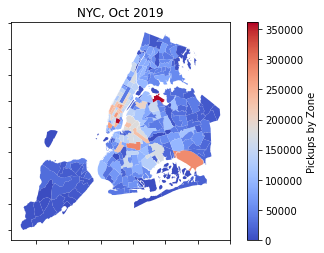

In [16]:
# plot PU trip heatmap
fig, ax = plt.subplots(1, 1)
plt.title('NYC, Oct 2019')
ax.set_yticklabels([])
ax.set_xticklabels([])
gdf.plot(cmap='coolwarm',
         column='Trips_by_PULocationID',
         ax=ax,
         legend=True,
         legend_kwds={'label': "Pickups by Zone", 'orientation': "vertical"})
plt.savefig('/media/felipe/Files/repos/tcc/nyc_data/imgs/2019-10_PU.jpg')

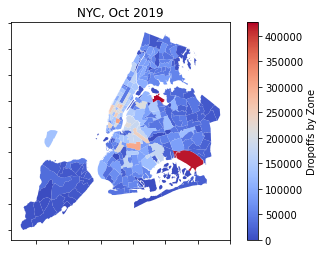

In [17]:
# plot DO trip heatmap
fig, ax = plt.subplots(1, 1)
plt.title('NYC, Oct 2019')
ax.set_yticklabels([])
ax.set_xticklabels([])
gdf.plot(cmap='coolwarm',
         column='Trips_by_DOLocationID',
         ax=ax,
         legend=True,
         legend_kwds={'label': "Dropoffs by Zone", 'orientation': "vertical"})
plt.savefig('/media/felipe/Files/repos/tcc/nyc_data/imgs/2019-10_DO.jpg')

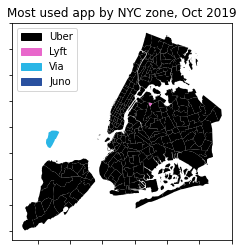

In [18]:
# plot top companies
fig, ax = plt.subplots(1, 1)
plt.title('Most used app by NYC zone, Oct 2019')
uber_patch = mpatches.Patch(color='#000000', label='Uber')
lyft_patch = mpatches.Patch(color='#E867CB', label='Lyft')
via_patch = mpatches.Patch(color='#2AB6E6', label='Via')
juno_patch = mpatches.Patch(color='#29509F', label='Juno')
no_data_patch = mpatches.Patch(color='#808080', label='No data')
plt.legend(handles=[uber_patch,lyft_patch,via_patch,juno_patch], loc='upper left')
ax.set_yticklabels([])
ax.set_xticklabels([])
gdf.plot(color=gdf['Top_Company_Color'],
         ax=ax,
         legend=True)
plt.savefig('/media/felipe/Files/repos/tcc/nyc_data/imgs/2019-10_App.jpg')